# Failure Pareto for Test Results
This notebook creates a failure pareto report for test results. It ties into the **Test Monitor Service** for retrieving filtered test results, the **Notebook Execution Service** for running outside of Jupyterhub, and **File Service** to store analysis result.


### Imports
Import Python modules for executing the notebook. Pandas is used for building and handling dataframes. Scrapbook is used for recording data for the Notebook Execution Service. The SystemLink Test Monitor Client provides access to test result data for processing.

In [17]:
import copy
import datetime
import os
import pandas as pd
import scrapbook as sb
from dateutil import tz
import io
import matplotlib.pyplot as plt

# Import SystemLink clients
from nisystemlink.clients.core import HttpConfiguration
from nisystemlink.clients.testmonitor import TestMonitorClient
from nisystemlink.clients.testmonitor.models import (
    CreateResultRequest,
    QueryResultsRequest,
    QueryResultValuesRequest,
    ResultField,
    Status,
    StatusType,
    UpdateResultRequest,
)

from nisystemlink.clients.product import ProductClient
from nisystemlink.clients.product.models import (
    CreateProductRequest,
    ProductField,
    ProductOrderBy,
    QueryProductsRequest,
    QueryProductValuesRequest,
)

from nisystemlink.clients.file import FileClient

### Parameters
- `result_ids`: IDs of the test results.

Parameters are also listed in the metadata for the parameters cell, along with their default values. The Notebook Execution services uses that metadata to pass parameters to this notebook. To see the metadata, select the code cell and click the wrench icon in the far left panel.

Sample metadata:

```json
{
  "papermill": {
    "parameters": {
      "result_ids": []
    }
  },
  "systemlink": {
    "namespaces": [],
    "parameters": [
      {
        "display_name": "result_ids",
        "id": "result_ids",
        "type": "string[]"
      }
    ],
    "version": 2
  },
  "tags": ["parameters"]
}
```

For more information on how parameterization works, review the [papermill documentation](https://papermill.readthedocs.io/en/latest/usage-parameterize.html#how-parameters-work).

In [18]:
result_ids = [
    "52da240b-3fac-4629-9907-09062a557ee0",
    "9d22e02f-1a96-4e7c-a573-effee83b6e5f",
    "c019cb82-8966-408e-b841-5d26a6d926c3",
    "f8c28c46-4560-4760-b204-dc60c6b44472",
    "4f365ad0-06c1-4df5-ab47-6cd4f823e475",
    "b8ed3a91-8b01-430e-ab28-93c7044ed1dd",
    "2a837c66-13fb-4c36-88c8-e100f9e62fd2",
    "a7e6e3c9-d36d-4376-97c9-2640bdbae909",
    "0539018b-b4ba-403c-bc6a-423d0d9070f3",
    "3c1b7a0b-26b8-409b-b668-005d2a1b1bae",
    "4394063f-1e4e-44f8-9ebf-51fb25f6f381",
    "c099edb5-2123-4748-b6fc-0b49d1fbc929",
    "f4f83a44-94b2-434d-b91a-8779d267d123",
    "e4bf2e33-ab6e-42ab-871b-806642a90770",
    "ffb1f286-7628-4516-b8dd-bb1357c27c3f",
    "0663c7c3-bfe7-420f-bb76-c09cffa1279c",
    "4378c234-530d-4ec8-b939-919abc7faab3",
    "6009140a-4959-4b76-85e9-4eb50d2c975c",
    "70ec2e7a-c1f8-42d6-a039-b8643512bb4f",
    "7866b4ea-8229-4a23-8611-79ef80cb1d28",
    "7d6b4b2a-e7d6-4126-922c-b8ad0fbf507c",
    "b2444f44-8461-4ce6-9432-a335429bc81e",
    "b58591e8-f08b-4958-9f2c-5d187e0bfc68",
    "e06e480f-23ab-4554-a0ce-ec97a05dfc33",
    "e7c06260-f836-46c6-9dd5-befda3d34148",
    "09363a43-06bb-47d3-9009-fe67a0d85fc7",
    "1cc80331-b47c-47bf-a6ea-29a1ead1c94b",
    "53e16e09-859d-4411-beb5-0dac044f5aa0",
    "b1423a65-b96a-4e6c-85d4-3a0b54584357",
    "ba32dbe2-6703-4ff5-8762-1dadbd9a8ea6",
    "be48d6e1-be59-40d4-b382-814bd12821cf",
    "cd81d71a-4f60-4fc8-b0ac-1ffc510514ad",
    "d48b390b-d64a-4356-917d-508d7a2dda1e",
    "da29e33f-5b76-4838-b54f-0497b41577f8",
    "dae57631-e2eb-4dfa-93ec-e619fde5d32d",
    "de87982a-8c65-48af-806f-cc9a51e9124e",
    "debd1351-28f6-4f00-8d85-27e72b802f2b",
    "079a6ce6-7cfd-4b0d-ba29-b4944a955c9d",
    "31263a93-d952-4ae7-8126-81562063174e",
    "6192087d-c981-4298-91e8-5fd238f8275c",
    "84062ce7-5aa5-4769-b75a-3dd1152b2545",
    "9a62b6a6-15b3-42e9-8a3d-3ce9a00a05a0",
    "9ef1b679-37ba-46cd-8850-b9c1ad50c989",
    "a4008572-1103-492e-85be-ed99c899b988",
    "c1d6c2be-e793-4604-8a02-de9ebc6feac2",
    "cd8365e0-567d-4fa3-aced-7ed30e1b6d52",
    "e42c4137-9214-40f7-9473-274769b3944c",
    "eb16cd8e-eb7b-47e1-b2ea-4f9759763af5",
    "f3816a72-9404-4403-9904-e43c22d9df95",
    "0b5b7de7-c8d5-4b49-9ee4-16736a4157a2",
    "0e26c218-265b-46d7-a094-88d7045e23a2",
    "11deaff1-cd80-40a3-8506-091addc6dd1d",
    "23cbb57d-99f2-4dce-9d11-377bbf123522",
    "23d2ac70-70f4-4ca4-98d7-21df353cee5e",
    "33bf4fe5-4a9c-47e7-ba92-aca7866349b7",
    "3872daf7-a7d1-4288-bf49-839b29fa8aab",
    "62072993-2979-41d1-a068-b3202b8491fa",
    "7d9b1e04-8030-4394-a29c-3aece02183c5",
    "89681c41-091d-4fb2-b900-40919b0f96ba",
    "959be11e-1774-4558-bbcc-d1fd5b3e837a",
    "97601b76-ad42-4ad7-8449-28b88221af28",
    "ae5a9c7e-1211-483c-85dd-63e4f3aa91d5",
    "b711d0c5-1d7f-4a03-8b6d-dd912ac064f6",
    "d08ff7e4-c751-4355-8831-78ac1acd3b5e",
    "df8d8757-00af-4e42-8253-1c003c7d38e4",
    "02f366f0-f8d3-4f7c-9c7d-cf8cc3fa4a71",
    "31c19f8b-44ee-4370-a86c-e4d7938a68d5",
    "350c4eb7-b091-4f4a-bf83-c8c17cc87c4a",
    "40994a26-a01b-4f38-a79e-81d0f186f01c",
    "40fbbbda-4c18-4367-9205-c14da300b7a9",
    "64c65557-33ef-474d-941d-ccd3b872f832",
    "9cb90f3e-70a0-47d3-a200-c1a5b8589144",
    "a83dd5ca-58a2-409d-b80d-6e6e91e0c3a3",
    "d28832d9-2847-41b0-95e3-7ce55c23343e"
]


#### Constants

In [19]:
PART_NUMBER = 'Part Number'
PLOT_FILE_NAME = "pareto_graph.png"

### Create Test Monitor client
Establish a connection to SystemLink over HTTP in two steps.
1. Builds an HTTPConfiguration object.
2. Injects them into the API constructors.

## Building an HTTPConfiguration object

In this part, we want to obtain both the remote server URI and the API key. This information is required by the APIs so that they can make the request to the right resources with proper access rights.

It has three different approaches for getting this information:
1. It tries to get the environment variables form the SystemLink server. If if fails.
2. It tries to load the .env file and read the variables from it. If this also fails.
3. It tries to uplaod from a local .json file

the `get_server_configuration()` function gets the required server information and returns an `HTTPConfiguration` object.

In [20]:
def get_server_configuration():
    # Load server URL and API key from environment variables or JSON file
    server_uri = os.getenv("SYSTEMLINK_HTTP_URI")
    api_key = os.getenv("SYSTEMLINK_API_KEY")

    if not (server_uri and api_key):
        try:
            from dotenv import load_dotenv
            load_dotenv()
            server_uri = os.getenv("SYSTEMLINK_HTTP_URI")
            api_key = os.getenv("SYSTEMLINK_API_KEY")
            print("Loaded configuration from .env file.")
        except ImportError:
            print("[Warning] Unable to locate dotenv module; skipping .env loading.")

    if not (server_uri and api_key):
        with open('SystemLink_API_KEY.json') as f:
            import json
            config_data = json.load(f)
            server_uri = config_data['systemlink_http_uri']
            api_key = config_data['api_key']

    return HttpConfiguration(server_uri=server_uri, api_key=api_key)

server_configuration = get_server_configuration()

## Injecting the HTTPConfiguration and Building the API Objects

At this moment we can build the API objects by calling the constructors and passing the HTTPConfiguration object stored in the `server_configuration` variable as the input parameter.

In [21]:
testmon_api = TestMonitorClient(server_configuration)
files_api = FileClient(server_configuration)
products_api = ProductClient(server_configuration)

### Query for results
Query the Test Monitor Service for results matching the `results_filter` parameter.

In [ ]:

final_results_filter = ""
for count, result_id in enumerate(result_ids[:-1], start = 1):
    final_results_filter += f'id == "{result_id}" || '

final_results_filter += f'(id == "{result_ids[-1]}") '
final_results_filter += '&& (status.statusType == "FAILED")'

#Create a query to get the results
results_query = QueryResultsRequest(
    filter=final_results_filter,
    order_by=ResultField.STARTED_AT,
    continuation_token=None,
    take=1,  # Adjust the limit as needed
)

results = []

response = testmon_api.query_results(results_query)
while response.continuation_token:
    results = results + response.results
    results_query.continuation_token = response.continuation_token
    response = testmon_api.query_results(results_query)


workspace_id = results[0].workspace
part_numbers = [result.part_number for result in results]

Final Results Filter: id == "52da240b-3fac-4629-9907-09062a557ee0" || id == "9d22e02f-1a96-4e7c-a573-effee83b6e5f" || id == "c019cb82-8966-408e-b841-5d26a6d926c3" || id == "f8c28c46-4560-4760-b204-dc60c6b44472" || id == "4f365ad0-06c1-4df5-ab47-6cd4f823e475" || id == "b8ed3a91-8b01-430e-ab28-93c7044ed1dd" || id == "2a837c66-13fb-4c36-88c8-e100f9e62fd2" || id == "a7e6e3c9-d36d-4376-97c9-2640bdbae909" || id == "0539018b-b4ba-403c-bc6a-423d0d9070f3" || id == "3c1b7a0b-26b8-409b-b668-005d2a1b1bae" || id == "4394063f-1e4e-44f8-9ebf-51fb25f6f381" || id == "c099edb5-2123-4748-b6fc-0b49d1fbc929" || id == "f4f83a44-94b2-434d-b91a-8779d267d123" || id == "e4bf2e33-ab6e-42ab-871b-806642a90770" || id == "ffb1f286-7628-4516-b8dd-bb1357c27c3f" || id == "0663c7c3-bfe7-420f-bb76-c09cffa1279c" || id == "4378c234-530d-4ec8-b939-919abc7faab3" || id == "6009140a-4959-4b76-85e9-4eb50d2c975c" || id == "70ec2e7a-c1f8-42d6-a039-b8643512bb4f" || id == "7866b4ea-8229-4a23-8611-79ef80cb1d28" || id == "7d6b4b2a-e7

'5e24401b-fdb6-4185-8364-723164504590'

### Get Part Numbers
Collect the part numbers for each result.

In [23]:
part_numbers = []
for result in results:
    part_numbers.append(result.part_number)

### Create pandas dataframe
Put the data into a dataframe whose columns are test result id, status, and part number.

In [24]:
formatted_results = {
    'id': [result.id for result in results],
    'status': [result.status.status_type if result.status else None for result in results],
    'part_number': part_numbers
}

df_results = pd.DataFrame.from_dict(formatted_results)

df_results

,id,status,part_number
0,52da240b-3fac-4629-9907-09062a557ee0,StatusType.FAILED,14W794AK010
1,9d22e02f-1a96-4e7c-a573-effee83b6e5f,StatusType.FAILED,14W794AK010
2,c019cb82-8966-408e-b841-5d26a6d926c3,StatusType.FAILED,17RIEACZ010
3,f8c28c46-4560-4760-b204-dc60c6b44472,StatusType.FAILED,14W794AK010
4,4f365ad0-06c1-4df5-ab47-6cd4f823e475,StatusType.FAILED,14W794AK010
...,...,...,...
69,40fbbbda-4c18-4367-9205-c14da300b7a9,StatusType.FAILED,17RIEACZ010
70,64c65557-33ef-474d-941d-ccd3b872f832,StatusType.FAILED,17RIEACZ010
71,9cb90f3e-70a0-47d3-a200-c1a5b8589144,StatusType.FAILED,14W794AK010
72,a83dd5ca-58a2-409d-b80d-6e6e91e0c3a3,StatusType.FAILED,17RIEACZ010


In [25]:
df_results_copy = copy.copy(df_results)
df_results_copy.fillna(value='', inplace=True)

### Aggregate results into groups based on status
Aggregate the data for each unique part number and status.

In [26]:
df_grouped = df_results_copy.groupby(['part_number', 'status']).size().unstack(fill_value=0)
if 'PASSED' not in df_grouped:
    df_grouped['PASSED'] = 0
if 'FAILED' not in df_grouped:
    df_grouped['FAILED'] = 0
if 'ERRORED' not in df_grouped:
    df_grouped['ERRORED'] = 0

### Failure Pareto calculation
Count the number of test failures and calculate cumulative values for the pareto.

In [27]:
df_fail_count = pd.DataFrame(df_grouped['FAILED'] + df_grouped['ERRORED'])
total = df_fail_count[0].sum()
pareto_values = []
cumulative = 0
for data_member in df_fail_count[0]:
    cumulative += data_member
    pareto_values.append(100 * (cumulative / total))
df_pareto = df_fail_count.reset_index().set_axis(['part_number', 'fail_count'], axis=1)
df_pareto['cumulative'] = pareto_values

In [28]:
df_pareto['part_number'].replace(r'^$', 'No ' + PART_NUMBER, regex=True, inplace=True)

df_dict = {
    'columns': pd.io.json.build_table_schema(df_pareto, index=False)['fields'],
    'values': df_pareto.values,
}

pareto_graph = {
    "type": 'data_frame',
    'id': 'failure_pareto_results_graph',
    'data': df_dict,
    'config': {
        'title': 'Failure Pareto - Results by {}'.format(PART_NUMBER),
        'graph': {
            'axis_labels': [PART_NUMBER, 'Failure Count', 'Cumulative %'],
            'plots': [
                {'x': 'part_number', 'y': 'fail_count', 'style': 'BAR', 'GROUP_BY': ['part_number']},
                {'x': 'part_number', 'y': 'cumulative', 'secondary_y': True, 'style': 'LINE'}
            ],
            'orientation': 'VERTICAL'
        }
    }
}

/tmp/ipykernel_55/2419766519.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pareto['part_number'].replace(r'^$', 'No ' + PART_NUMBER, regex=True, inplace=True)


### Generate plot PNG

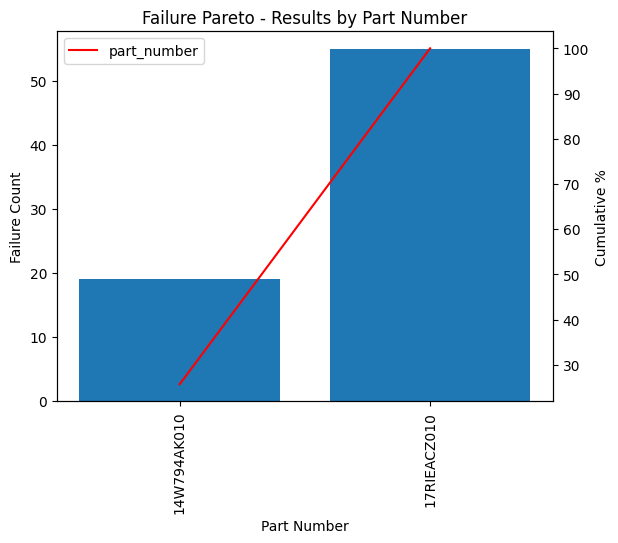

In [29]:
# Extract data from the pareto_graph dictionary
title = pareto_graph['config']['title']
axis_labels = pareto_graph['config']['graph']['axis_labels']
plots = pareto_graph['config']['graph']['plots']

# Plot data
fig, ax1 = plt.subplots()

for plot in plots:
    if plot['style'] == 'BAR':
        ax1.bar(
            df_pareto[plot['x']], 
            df_pareto[plot['y']], 
            label=plot['x'])
        ax1.set_ylabel(axis_labels[1])
        ax1.set_xlabel(axis_labels[0])
    elif plot['style'] == 'LINE':
        ax2 = ax1.twinx()
        ax2.plot(df_pareto[plot['x']], df_pareto[plot['y']], label=plot['x'], color='r')
        ax2.set_ylabel(axis_labels[2])

# Title and legend
plt.title(title)
plt.legend()
ax1.tick_params(axis='x', labelrotation = 90)

# Save as PNG file
plt.savefig(PLOT_FILE_NAME, bbox_inches='tight')

# Show the plot (optional)
plt.show()



### Upload Plot to files service and link to products

In [30]:
# def upload_file(file_name, workspace=None):
#     filepath = os.path.join(os.getcwd(), file_name)
#     with open(filepath, 'rb') as file:
#         file_id = files_api.upload_file(file=file, workspace=workspace)

#     return file_id

# def get_products(part_numbers):
#     query_filter = ""
#     for part_number in part_numbers[:-1]:
#         query_filter += f'partNumber == "{part_number}" or '

#     query_filter += f'partNumber == "{part_numbers[-1]}"'
#     query_body = {"filter": query_filter}

#     query_request = QueryProductsRequest(
#         filter=query_filter
#         )
    
#     products = []

#     response = products_api.query_products_paged(query_request)
#     while response.continuation_token:
#         products = products + response.products
#         query_request.continuation_token = response.continuation_token
#         response = products_api.query_products_paged(query_request)

#     return products

# def add_file_id_to_products(part_numbers, file_id):
#     products = get_products(part_numbers)
#     for product in products:
#         product.file_ids.append(file_id)
#     response = products_api.update_products(products=products, replace=False)

#     return products

In [31]:
# uploaded_file_id = upload_file(file_name=PLOT_FILE_NAME, workspace=workspace_id)
# products = add_file_id_to_products(
#     part_numbers, file_id=uploaded_file_id
# )
# product_id = products[0].id

### Record results with Scrapbook

In [32]:
# sb.glue(
#     "The resultant failure pareto analysis is uploaded as an image",
#     f'<a href="../../testinsights/products/product/{product_id}/files">Link to image</a>',
# )

### Next Steps

1. Publish this notebook to SystemLink by right-clicking it in the JupyterLab File Browser with the interface as Test Data Analysis.
1. Manually Analyze the results inside results grid by clicking analyze button.